In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping


SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
sns.set(style="whitegrid")


In [2]:

# Load data
df = pd.read_csv("/content/drive/MyDrive/Excelr/Assignments/DataSets/monthly_milk_production.csv")
try:
    df['Date'] = pd.to_datetime(df['Date'])
except Exception:
    df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True, errors='coerce')
df = df.sort_values('Date').reset_index(drop=True)


In [3]:
df

,Date,Production
0,1962-01-01,589
1,1962-02-01,561
2,1962-03-01,640
3,1962-04-01,656
4,1962-05-01,727
...,...,...
163,1975-08-01,858
164,1975-09-01,817
165,1975-10-01,827
166,1975-11-01,797


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        168 non-null    datetime64[ns]
 1   Production  168 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.8 KB


In [5]:
df.describe()

,Date,Production
count,168,168.000000
mean,1968-12-15 16:17:08.571428572,754.708333
min,1962-01-01 00:00:00,553.000000
25%,1965-06-23 12:00:00,677.750000
50%,1968-12-16 12:00:00,761.000000
75%,1972-06-08 12:00:00,824.500000
max,1975-12-01 00:00:00,969.000000
std,NaN,102.204524


In [6]:
df.isnull().sum()

,0
Date,0
Production,0


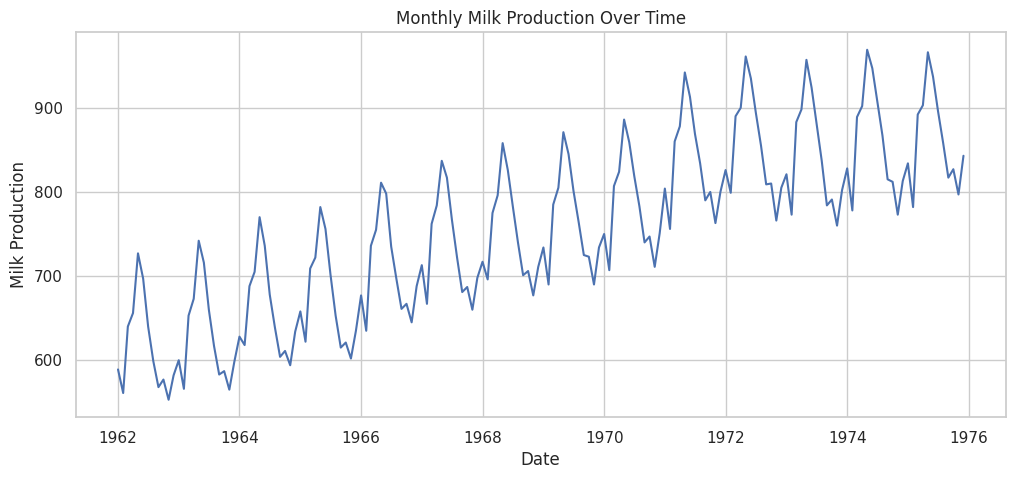

In [7]:
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['Production'])
plt.title("Monthly Milk Production Over Time")
plt.xlabel("Date")
plt.ylabel("Milk Production")
plt.show()


Text(0.5, 1.0, 'Milk Production Distribution')

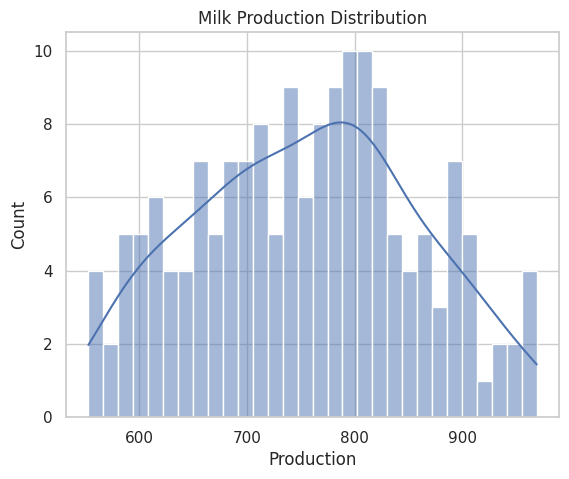

In [8]:
# Distribution and boxplot
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.histplot(df['Production'], bins=30, kde=True)
plt.title('Milk Production Distribution')


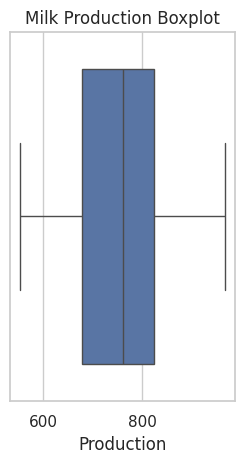

In [9]:

plt.subplot(1,2,2)
sns.boxplot(x=df['Production'])
plt.title('Milk Production Boxplot')
plt.show()


In [10]:
# Scale data
scaler = MinMaxScaler()
production_scaled = scaler.fit_transform(df['Production'].values.reshape(-1, 1))


In [11]:
# Sequence creation
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)


In [12]:
# Train-val-test split
def train_val_test_split(X, y, train_ratio=0.7, val_ratio=0.15):
    n = len(X)
    train_end = int(train_ratio * n)
    val_end = int((train_ratio + val_ratio) * n)

    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end:val_end], y[train_end:val_end]
    X_test, y_test = X[val_end:], y[val_end:]
    return X_train, y_train, X_val, y_val, X_test, y_test


In [13]:
# Build model function
def build_model(cell_type, units, window_size):
    model = Sequential()
    if cell_type == 'RNN':
        model.add(SimpleRNN(units, input_shape=(window_size, 1)))
    elif cell_type == 'LSTM':
        model.add(LSTM(units, input_shape=(window_size, 1)))
    elif cell_type == 'GRU':
        model.add(GRU(units, input_shape=(window_size, 1)))
    else:
        raise ValueError("Unknown cell_type")
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model


In [14]:
# Evaluation function
def evaluate_model(model, X, y, scaler):
    y_pred_scaled = model.predict(X)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_true = scaler.inverse_transform(y)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mae, mape, y_pred, y_true


In [15]:
# Hyperparameter grids
window_sizes = [6, 12, 18]
units_list = [16, 32, 64]
batch_sizes = [16, 32]
epochs_list = [50, 100]
cell_types = ['RNN', 'LSTM', 'GRU']

best_metrics = {}
best_models = {}
best_histories = {}



In [16]:
# Hyperparameter tuning loop
for cell_type in cell_types:
    best_rmse = np.inf
    best_params = None
    best_model = None
    best_history = None

    for window_size in window_sizes:
        X, y = create_sequences(production_scaled, window_size)
        X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X, y)
        X_train = X_train.reshape((X_train.shape[0], window_size, 1))
        X_val = X_val.reshape((X_val.shape[0], window_size, 1))
        X_test = X_test.reshape((X_test.shape[0], window_size, 1))
        y_train = y_train.reshape((-1,1))
        y_val = y_val.reshape((-1,1))
        y_test = y_test.reshape((-1,1))

        for units in units_list:
            for batch_size in batch_sizes:
                for epochs in epochs_list:
                    print(f"\nTraining {cell_type} | window={window_size}, units={units}, batch={batch_size}, epochs={epochs}")
                    model = build_model(cell_type, units, window_size)
                    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
                    history = model.fit(X_train, y_train, validation_data=(X_val,y_val),
                                        epochs=epochs, batch_size=batch_size, callbacks=[early_stop], verbose=0)
                    rmse, mae, mape, _, _ = evaluate_model(model, X_val, y_val, scaler)
                    print(f"Val RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_params = {'window_size': window_size, 'units': units, 'batch_size': batch_size, 'epochs': epochs}
                        best_model = model
                        best_history = history

    best_metrics[cell_type] = {'rmse': best_rmse, 'params': best_params}
    best_models[cell_type] = best_model
    best_histories[cell_type] = best_history



Training RNN | window=6, units=16, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Val RMSE: 40.2290, MAE: 30.1341, MAPE: 3.50%

Training RNN | window=6, units=16, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Val RMSE: 50.0756, MAE: 36.7453, MAPE: 4.20%

Training RNN | window=6, units=16, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Val RMSE: 91.3665, MAE: 70.4849, MAPE: 7.92%

Training RNN | window=6, units=16, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Val RMSE: 39.8152, MAE: 32.1445, MAPE: 3.74%

Training RNN | window=6, units=32, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Val RMSE: 44.3410, MAE: 34.6338, MAPE: 4.07%

Training RNN | window=6, units=32, batch=16, epochs=100


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Val RMSE: 39.8680, MAE: 30.7676, MAPE: 3.61%

Training RNN | window=6, units=32, batch=32, epochs=50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Val RMSE: 40.5674, MAE: 31.4670, MAPE: 3.66%

Training RNN | window=6, units=32, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Val RMSE: 44.9171, MAE: 33.6446, MAPE: 3.87%

Training RNN | window=6, units=64, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
Val RMSE: 50.2716, MAE: 39.8377, MAPE: 4.54%

Training RNN | window=6, units=64, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Val RMSE: 42.4407, MAE: 32.2284, MAPE: 3.78%

Training RNN | window=6, units=64, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Val RMSE: 74.3058, MAE: 60.5661, MAPE: 6.94%

Training RNN | window=6, units=64, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Val RMSE: 39.2514, MAE: 30.3628, MAPE: 3.53%

Training RNN | window=12, units=16, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Val RMSE: 56.0927, MAE: 45.2214, MAPE: 5.09%

Training RNN | window=12, units=16, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Val RMSE: 19.9845, MAE: 15.8116, MAPE: 1.89%

Training RNN | window=12, units=16, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Val RMSE: 40.0481, MAE: 32.4518, MAPE: 3.78%

Training RNN | window=12, units=16, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Val RMSE: 29.9961, MAE: 25.0137, MAPE: 2.87%

Training RNN | window=12, units=32, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Val RMSE: 26.4768, MAE: 21.6202, MAPE: 2.49%

Training RNN | window=12, units=32, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Val RMSE: 21.5800, MAE: 17.4893, MAPE: 2.08%

Training RNN | window=12, units=32, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Val RMSE: 68.2287, MAE: 57.9603, MAPE: 6.66%

Training RNN | window=12, units=32, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Val RMSE: 27.3302, MAE: 23.6374, MAPE: 2.79%

Training RNN | window=12, units=64, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Val RMSE: 19.9063, MAE: 16.4149, MAPE: 1.93%

Training RNN | window=12, units=64, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Val RMSE: 21.2317, MAE: 17.2858, MAPE: 2.08%

Training RNN | window=12, units=64, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
Val RMSE: 24.0825, MAE: 20.2346, MAPE: 2.38%

Training RNN | window=12, units=64, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Val RMSE: 29.3517, MAE: 26.1440, MAPE: 3.08%

Training RNN | window=18, units=16, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Val RMSE: 21.6453, MAE: 18.5401, MAPE: 2.22%

Training RNN | window=18, units=16, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Val RMSE: 62.7734, MAE: 52.1000, MAPE: 6.01%

Training RNN | window=18, units=16, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Val RMSE: 35.6682, MAE: 29.7202, MAPE: 3.46%

Training RNN | window=18, units=16, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Val RMSE: 35.8341, MAE: 30.7815, MAPE: 3.68%

Training RNN | window=18, units=32, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Val RMSE: 29.2152, MAE: 25.1848, MAPE: 3.01%

Training RNN | window=18, units=32, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Val RMSE: 17.5790, MAE: 13.9855, MAPE: 1.70%

Training RNN | window=18, units=32, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Val RMSE: 27.4537, MAE: 21.9986, MAPE: 2.62%

Training RNN | window=18, units=32, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Val RMSE: 25.3961, MAE: 21.3073, MAPE: 2.56%

Training RNN | window=18, units=64, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Val RMSE: 21.3533, MAE: 18.3878, MAPE: 2.22%

Training RNN | window=18, units=64, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Val RMSE: 19.9501, MAE: 16.3318, MAPE: 1.92%

Training RNN | window=18, units=64, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Val RMSE: 19.2109, MAE: 16.1178, MAPE: 1.91%

Training RNN | window=18, units=64, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Val RMSE: 23.8031, MAE: 19.9649, MAPE: 2.37%

Training LSTM | window=6, units=16, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
Val RMSE: 71.3185, MAE: 59.1481, MAPE: 6.82%

Training LSTM | window=6, units=16, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Val RMSE: 79.4413, MAE: 63.5525, MAPE: 7.21%

Training LSTM | window=6, units=16, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
Val RMSE: 70.8228, MAE: 56.7593, MAPE: 6.48%

Training LSTM | window=6, units=16, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Val RMSE: 77.3822, MAE: 61.0528, MAPE: 6.92%

Training LSTM | window=6, units=32, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Val RMSE: 72.0608, MAE: 62.1312, MAPE: 7.26%

Training LSTM | window=6, units=32, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Val RMSE: 73.5854, MAE: 63.0182, MAPE: 7.34%

Training LSTM | window=6, units=32, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Val RMSE: 72.1970, MAE: 62.0668, MAPE: 7.25%

Training LSTM | window=6, units=32, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
Val RMSE: 71.7527, MAE: 60.5046, MAPE: 7.02%

Training LSTM | window=6, units=64, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Val RMSE: 60.0108, MAE: 46.1203, MAPE: 5.24%

Training LSTM | window=6, units=64, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Val RMSE: 67.9070, MAE: 51.9643, MAPE: 5.86%

Training LSTM | window=6, units=64, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
Val RMSE: 74.3257, MAE: 63.4752, MAPE: 7.39%

Training LSTM | window=6, units=64, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
Val RMSE: 76.2441, MAE: 65.0202, MAPE: 7.57%

Training LSTM | window=12, units=16, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Val RMSE: 68.7972, MAE: 58.2869, MAPE: 6.69%

Training LSTM | window=12, units=16, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Val RMSE: 63.2156, MAE: 57.0756, MAPE: 6.72%

Training LSTM | window=12, units=16, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
Val RMSE: 60.0887, MAE: 52.5520, MAPE: 6.12%

Training LSTM | window=12, units=16, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Val RMSE: 65.5194, MAE: 58.9522, MAPE: 6.94%

Training LSTM | window=12, units=32, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Val RMSE: 35.0039, MAE: 28.8651, MAPE: 3.48%

Training LSTM | window=12, units=32, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Val RMSE: 28.7439, MAE: 23.2937, MAPE: 2.74%

Training LSTM | window=12, units=32, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
Val RMSE: 67.7770, MAE: 61.2633, MAPE: 7.22%

Training LSTM | window=12, units=32, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Val RMSE: 68.6137, MAE: 61.9375, MAPE: 7.31%

Training LSTM | window=12, units=64, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Val RMSE: 26.5239, MAE: 21.8647, MAPE: 2.61%

Training LSTM | window=12, units=64, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Val RMSE: 32.7214, MAE: 26.2599, MAPE: 3.17%

Training LSTM | window=12, units=64, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Val RMSE: 30.8783, MAE: 25.3458, MAPE: 2.93%

Training LSTM | window=12, units=64, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Val RMSE: 37.3173, MAE: 29.9486, MAPE: 3.67%

Training LSTM | window=18, units=16, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
Val RMSE: 66.5891, MAE: 57.9106, MAPE: 6.75%

Training LSTM | window=18, units=16, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Val RMSE: 63.8257, MAE: 56.5029, MAPE: 6.66%

Training LSTM | window=18, units=16, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Val RMSE: 62.8136, MAE: 54.5708, MAPE: 6.40%

Training LSTM | window=18, units=16, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Val RMSE: 63.8795, MAE: 54.8907, MAPE: 6.40%

Training LSTM | window=18, units=32, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
Val RMSE: 61.4677, MAE: 54.5464, MAPE: 6.55%

Training LSTM | window=18, units=32, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Val RMSE: 43.1270, MAE: 33.7340, MAPE: 4.07%

Training LSTM | window=18, units=32, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Val RMSE: 67.5317, MAE: 60.7845, MAPE: 7.22%

Training LSTM | window=18, units=32, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Val RMSE: 65.3067, MAE: 58.4656, MAPE: 6.92%

Training LSTM | window=18, units=64, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Val RMSE: 65.2040, MAE: 58.1236, MAPE: 6.93%

Training LSTM | window=18, units=64, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Val RMSE: 36.6903, MAE: 27.8809, MAPE: 3.33%

Training LSTM | window=18, units=64, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Val RMSE: 60.3355, MAE: 53.1291, MAPE: 6.38%

Training LSTM | window=18, units=64, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Val RMSE: 35.4564, MAE: 27.9062, MAPE: 3.36%

Training GRU | window=6, units=16, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
Val RMSE: 55.2697, MAE: 42.1535, MAPE: 4.80%

Training GRU | window=6, units=16, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
Val RMSE: 46.2483, MAE: 35.0261, MAPE: 4.06%

Training GRU | window=6, units=16, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
Val RMSE: 76.3987, MAE: 59.1570, MAPE: 6.65%

Training GRU | window=6, units=16, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
Val RMSE: 88.5080, MAE: 69.3410, MAPE: 7.78%

Training GRU | window=6, units=32, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
Val RMSE: 62.7581, MAE: 51.2579, MAPE: 5.89%

Training GRU | window=6, units=32, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
Val RMSE: 45.2328, MAE: 35.9173, MAPE: 4.18%

Training GRU | window=6, units=32, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
Val RMSE: 62.7146, MAE: 52.0191, MAPE: 6.00%

Training GRU | window=6, units=32, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Val RMSE: 93.0394, MAE: 71.4254, MAPE: 8.00%

Training GRU | window=6, units=64, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
Val RMSE: 38.6866, MAE: 29.9080, MAPE: 3.52%

Training GRU | window=6, units=64, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
Val RMSE: 38.5460, MAE: 29.3751, MAPE: 3.46%

Training GRU | window=6, units=64, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
Val RMSE: 63.3554, MAE: 52.6292, MAPE: 6.08%

Training GRU | window=6, units=64, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
Val RMSE: 66.0004, MAE: 55.5251, MAPE: 6.42%

Training GRU | window=12, units=16, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
Val RMSE: 70.4520, MAE: 54.3149, MAPE: 6.10%

Training GRU | window=12, units=16, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
Val RMSE: 34.7331, MAE: 28.0236, MAPE: 3.26%

Training GRU | window=12, units=16, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
Val RMSE: 63.5607, MAE: 49.8037, MAPE: 5.65%

Training GRU | window=12, units=16, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
Val RMSE: 77.4964, MAE: 59.7009, MAPE: 6.68%

Training GRU | window=12, units=32, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
Val RMSE: 64.0218, MAE: 54.1328, MAPE: 6.26%

Training GRU | window=12, units=32, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
Val RMSE: 62.0971, MAE: 51.0680, MAPE: 5.87%

Training GRU | window=12, units=32, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
Val RMSE: 63.7217, MAE: 55.2562, MAPE: 6.46%

Training GRU | window=12, units=32, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
Val RMSE: 62.1302, MAE: 52.5501, MAPE: 6.08%

Training GRU | window=12, units=64, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
Val RMSE: 65.2139, MAE: 58.0675, MAPE: 6.86%

Training GRU | window=12, units=64, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
Val RMSE: 62.8339, MAE: 56.0935, MAPE: 6.64%

Training GRU | window=12, units=64, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
Val RMSE: 68.1361, MAE: 61.3217, MAPE: 7.26%

Training GRU | window=12, units=64, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
Val RMSE: 66.2064, MAE: 59.2701, MAPE: 7.01%

Training GRU | window=18, units=16, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
Val RMSE: 70.6315, MAE: 54.6371, MAPE: 6.15%

Training GRU | window=18, units=16, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
Val RMSE: 58.6537, MAE: 47.9438, MAPE: 5.52%

Training GRU | window=18, units=16, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
Val RMSE: 78.5113, MAE: 60.5952, MAPE: 6.81%

Training GRU | window=18, units=16, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
Val RMSE: 80.9980, MAE: 61.9118, MAPE: 6.93%

Training GRU | window=18, units=32, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Val RMSE: 59.7557, MAE: 50.6031, MAPE: 5.89%

Training GRU | window=18, units=32, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
Val RMSE: 59.0835, MAE: 49.6214, MAPE: 5.76%

Training GRU | window=18, units=32, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
Val RMSE: 59.9281, MAE: 50.9889, MAPE: 5.96%

Training GRU | window=18, units=32, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
Val RMSE: 59.6795, MAE: 50.5236, MAPE: 5.90%

Training GRU | window=18, units=64, batch=16, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
Val RMSE: 29.8166, MAE: 22.4248, MAPE: 2.67%

Training GRU | window=18, units=64, batch=16, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
Val RMSE: 29.9312, MAE: 22.4757, MAPE: 2.67%

Training GRU | window=18, units=64, batch=32, epochs=50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
Val RMSE: 64.0942, MAE: 54.4470, MAPE: 6.32%

Training GRU | window=18, units=64, batch=32, epochs=100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
Val RMSE: 31.1123, MAE: 23.1965, MAPE: 2.76%


In [17]:
# Summary of best hyperparameters and metrics
print("\nBest Hyperparameters and Validation RMSE:")
for model_type, vals in best_metrics.items():
    print(f"{model_type}: RMSE={vals['rmse']:.4f} with params {vals['params']}")



Best Hyperparameters and Validation RMSE:
RNN: RMSE=17.5790 with params {'window_size': 18, 'units': 32, 'batch_size': 16, 'epochs': 100}
LSTM: RMSE=26.5239 with params {'window_size': 12, 'units': 64, 'batch_size': 16, 'epochs': 50}
GRU: RMSE=29.8166 with params {'window_size': 18, 'units': 64, 'batch_size': 16, 'epochs': 50}


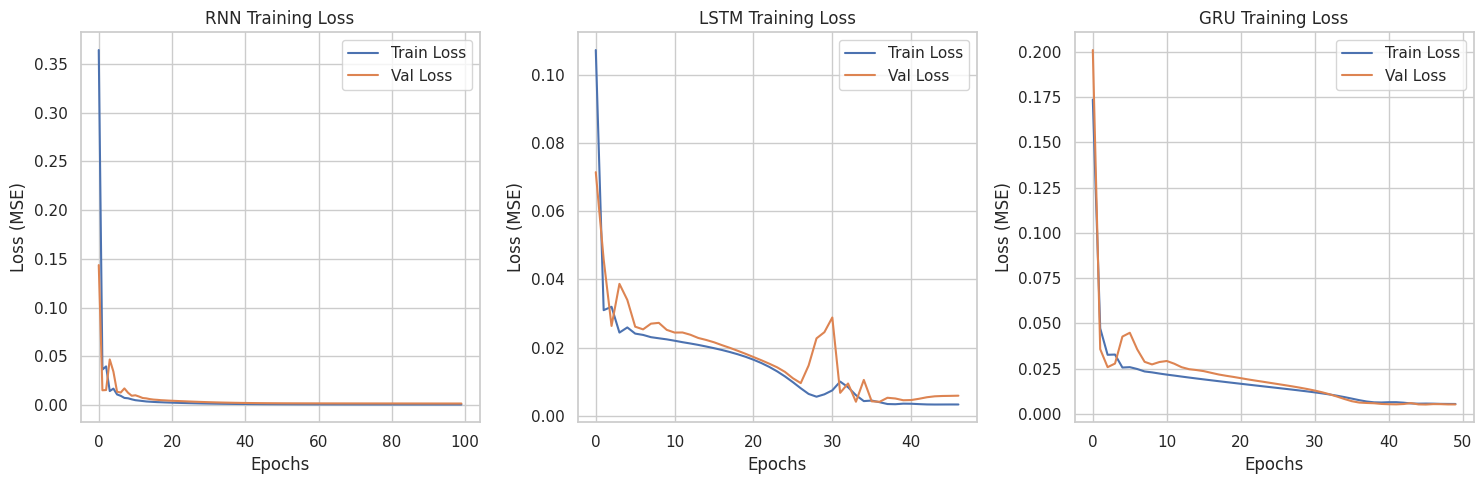

In [18]:
# Plot training-loss curves for best models
plt.figure(figsize=(15,5))
for i, model_type in enumerate(cell_types, 1):
    history = best_histories[model_type]
    plt.subplot(1,3,i)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"{model_type} Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step

Test performance for RNN - RMSE:13.1020, MAE:11.1929, MAPE:1.32%


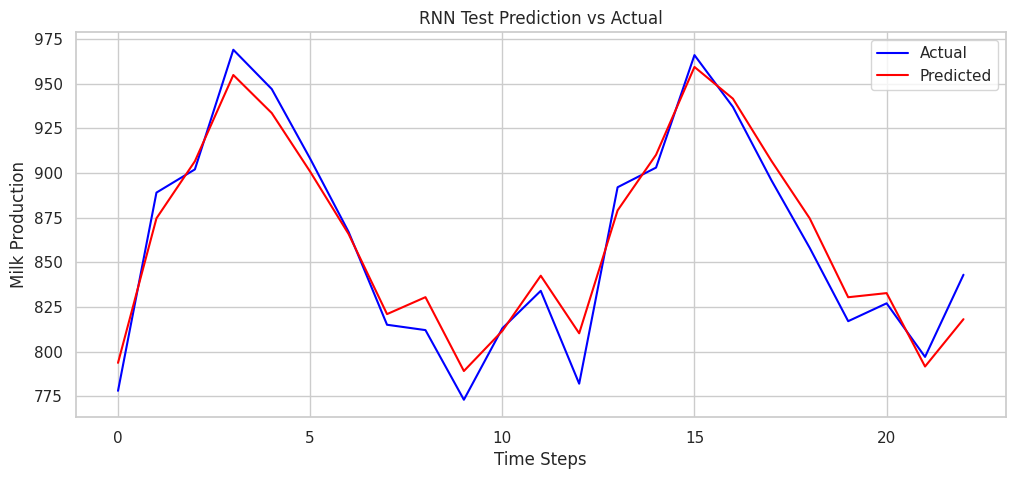

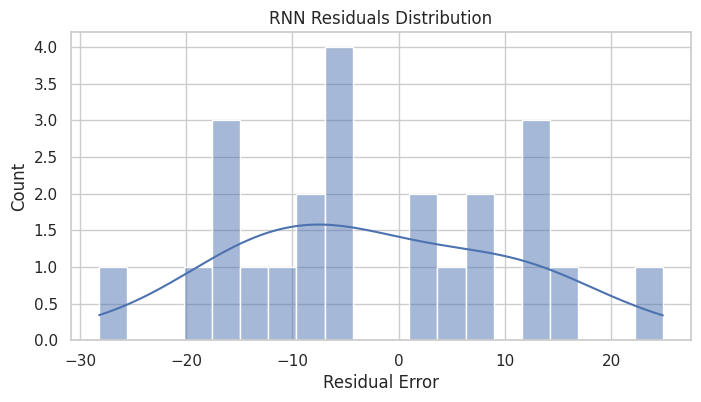

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step

Test performance for LSTM - RMSE:26.7590, MAE:21.9491, MAPE:2.58%


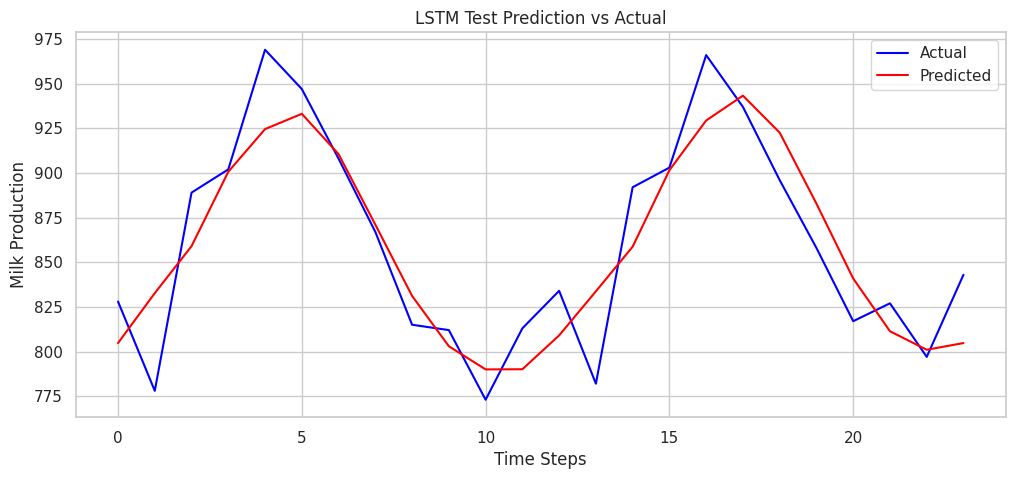

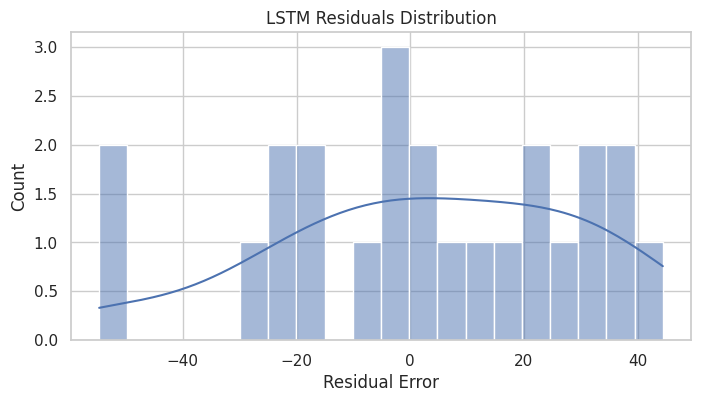

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step

Test performance for GRU - RMSE:34.9693, MAE:26.8918, MAPE:3.17%


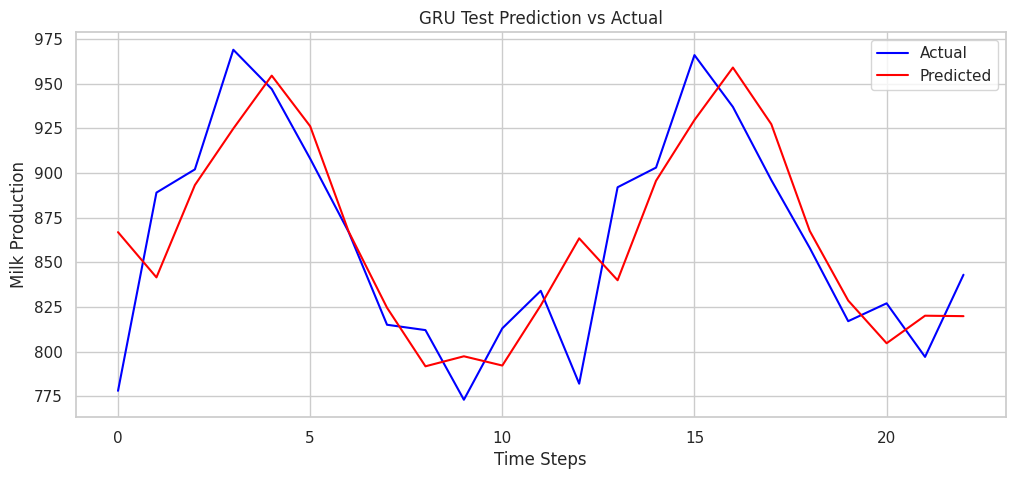

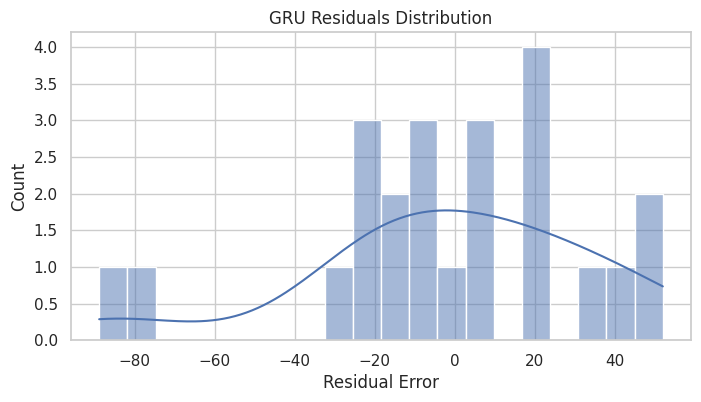

In [22]:

# Evaluate best models on test set and plot predictions
for model_type in cell_types:
    params = best_metrics[model_type]['params']
    window_size = params['window_size']

    X, y = create_sequences(production_scaled, window_size)
    _, _, _, _, X_test, y_test = train_val_test_split(X, y)
    X_test = X_test.reshape((X_test.shape[0], window_size, 1))
    y_test = y_test.reshape((-1, 1))

    model = best_models[model_type]
    rmse, mae, mape, y_pred, y_true = evaluate_model(model, X_test, y_test, scaler)

    print(f"\nTest performance for {model_type} - RMSE:{rmse:.4f}, MAE:{mae:.4f}, MAPE:{mape:.2f}%")

    plt.figure(figsize=(12,5))
    plt.plot(y_true, label='Actual', color='blue')
    plt.plot(y_pred, label='Predicted', color='red')
    plt.title(f'{model_type} Test Prediction vs Actual')
    plt.xlabel('Time Steps')
    plt.ylabel('Milk Production')
    plt.legend()
    plt.show()

    residuals = y_true - y_pred
    plt.figure(figsize=(8,4))
    sns.histplot(residuals.flatten(), bins=20, kde=True)
    plt.title(f'{model_type} Residuals Distribution')
    plt.xlabel('Residual Error')
    plt.show()



Interpretation:
- The model with the lowest RMSE on test set is considered 'best' for point forecasting in this experiment.
- LSTM/GRU often capture longer temporal dependencies and seasonality better than a vanilla RNN.
- If the best model still shows large MAPE, consider additional feature engineering (exogenous regressors like temperature, feed inputs),
  or increase model capacity and training epochs, or use seasonal decomposition + model residuals.
Practical recommendations:
- Use the 12-month point forecasts for inventory planning, but apply a conservative safety stock considering forecast uncertainty.
- Re-train models monthly as new data arrives (rolling/online retraining).
- For production use, evaluate forecast on out-of-sample holdout (or cross-validated time-series splits).

